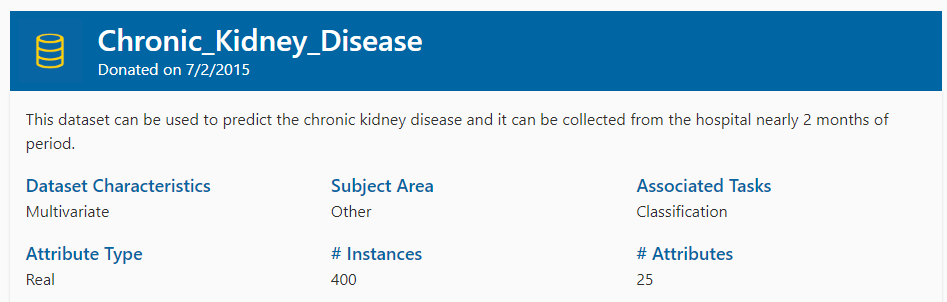


##  Data    
<a href="https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease">UCI Machine Learning</a>,   <a href="https://www.kaggle.com/datasets/mansoordaku/ckdisease?resource=download">Kaggle</a>
    

## Objectives

After completing this lab you will be able to:

* Use <a href="https://snapml.readthedocs.io/en/latest/decision_trees.html">IBM snapML</a> to Support Vector Machine to classify


## **Additional Information**

We use the following representation to collect the dataset
            age		-	age	              <br>
			bp		-	blood pressure    <br>
			sg		-	specific gravity  <br>
			al		-   	albumin       <br>
			su		-	sugar             <br>            
			rbc		-	red blood cells   <br>
			pc		-	pus cell          <br>
			pcc		-	pus cell clumps   <br>
			ba		-	bacteria          <br>
			bgr		-	blood glucose random   <br>
			bu		-	blood urea             <br>
			sc		-	serum creatinine       <br>
			sod		-	sodium                 <br>
			pot		-	potassium              <br>
			hemo		-	hemoglobin         <br>
			pcv		-	packed cell volume     <br>
			wc		-	white blood cell count <br>
			rc		-	red blood cell count   <br>
			htn		-	hypertension           <br>
			dm		-	diabetes mellitus      <br>
			cad		-	coronary artery disease <br>
			appet		-	appetite            <br>
			pe		-	pedal edema             <br>
			ane		-	anemia                   <br>
			class - (ckd,notckd)	            <br>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the Chronic KIdney Disease data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


## import packages


In [1]:
#!pip install snapml

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score
%matplotlib inline 
import matplotlib.pyplot as plt

# dealing with imbalance classes
from imblearn.over_sampling import SMOTE
from collections import Counter

# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data From CSV File  


In [3]:
kidney_disease_df = pd.read_csv("kidney_disease.csv")
kidney_disease_df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [4]:
# shape
kidney_disease_df.shape

(400, 26)

## Basic EDA

In [5]:
# check the columns
kidney_disease_df.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [6]:
# data types
kidney_disease_df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [7]:
# missing values
kidney_disease_df.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

## Let hadndle missing Nan :

Note the below method are efficient in finance and when working with timeseries data, you can't do this in health related issue because you can't write a that a patient is normal or not when the value is missing, this can be due to some other circumstances that such a data so it's better to do more research about why such value is not present before modelling.

In [18]:
# applying ffill() method to fill the missing values
# new_df = kidney_disease_df.ffill(axis = 0).copy()

In [19]:
# applying ffill() method to fill the missing values
# new_df = new_df.backfill(axis = 0)

In [20]:
# missing values
# new_df.isnull().sum()

In [21]:
# let's drop na value since most machine learning models don't know how to handle such values
kidney_disease_clean = kidney_disease_df.dropna().reset_index(drop=True)

In [22]:
# the shape after dropping the na, as we see almost 70% of the data is gone
kidney_disease_clean.shape

(158, 26)

In [23]:
# value count of the churn to see if we are dealing with a balanced or unbalanced dataset
kidney_disease_clean['classification'].value_counts(normalize=True)

notckd    0.727848
ckd       0.272152
Name: classification, dtype: float64

**Outcome column** : is unbalance with notckd making 72.78% of the data set and ckd 27.21%.

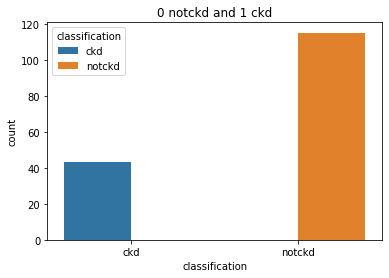

In [24]:
# now let's visualize the outcome
sns.countplot(data=kidney_disease_clean , x="classification", hue="classification").set(title = "0 notckd and 1 ckd");

## Data pre-processing and selection


In [25]:
# let's drop useless column like the id
kidney_disease_clean.drop(['id'], axis = 1, inplace = True) 

In [26]:
# check if the id has been dropped
kidney_disease_clean.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [27]:
# find and replace string notckd and ckd in the classification column  and convert from object type to int
kidney_disease_clean['classification'] = kidney_disease_clean['classification'].str.replace('notckd', '0')
kidney_disease_clean['classification'] = kidney_disease_clean['classification'].str.replace('ckd', '1')
kidney_disease_clean['classification'] = kidney_disease_clean['classification'].astype(int) # other methods can be labelencoding 

### Assign y(target) and X(input/features):

In [28]:
# target value
y =  kidney_disease_clean['classification']

In [29]:
# let's drop the classification column
kidney_disease_clean.drop(['classification'], axis = 1, inplace = True) 

In [30]:
# you see we have deleted the target column(classification)
kidney_disease_clean.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane'],
      dtype='object')

In [31]:
# dummy encode the 
feature_dum = pd.get_dummies(kidney_disease_clean, drop_first=True)


feature_dum.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,rc_6.3,rc_6.4,rc_6.5,rc_8.0,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes
0,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,0,0,0,1,0,0,1,1,1
1,53.0,90.0,1.020,2.0,0.0,70.0,107.0,7.2,114.0,3.7,...,0,0,0,0,1,1,0,1,0,1
2,63.0,70.0,1.010,3.0,0.0,380.0,60.0,2.7,131.0,4.2,...,0,0,0,0,1,1,0,1,1,0
3,68.0,80.0,1.010,3.0,2.0,157.0,90.0,4.1,130.0,6.4,...,0,0,0,0,1,1,1,1,1,0
4,61.0,80.0,1.015,2.0,0.0,173.0,148.0,3.9,135.0,5.2,...,0,0,0,0,1,1,1,1,1,1


## Train/Test dataset


We split our dataset into train and test set:


In [32]:
X = feature_dum.copy()
y = y.copy()

In [33]:
X.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
       ...
       'rc_6.3', 'rc_6.4', 'rc_6.5', 'rc_8.0', 'htn_yes', 'dm_yes', 'cad_yes',
       'appet_poor', 'pe_yes', 'ane_yes'],
      dtype='object', length=164)

In [34]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (126, 164) (126,)
Test set: (32, 164) (32,)


## Feature scaling


In [35]:
scaler = StandardScaler() # scaler objecy
X_train.loc[:,['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot','hemo']] = scaler.fit_transform(X_train[['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot','hemo']].to_numpy()
) # allow the scaler object to learn the features and transform the training data
X_test.loc[:,['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot','hemo']] =  scaler.transform(X_test[['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot','hemo']].to_numpy()
) # apply the learned features on the test set

In [36]:
# scaled x_train
X_train = np.asarray(X_train)
X_train.shape 

(126, 164)

In [37]:
# scaled x_test
X_test = np.asarray(X_test)
X_test.shape 

(32, 164)

<div id="svm_snap">
    <h2>Build a Support Vector Machine model with Snap ML</h2>
</div>


In [38]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs
# to use the GPU, set the use_gpu parameter to True
# snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(class_weight='balanced', kernel='rbf', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())

# train an SVM model using Snap ML
clf = snapml_svm.fit(X_train, y_train)

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Radial basis function (RBF)
   
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


After being fitted, the model can then be used to predict new values:


In [39]:
yhat = clf.predict(X_test)
yhat [0:5]

array([0, 1, 0, 1, 0])

<h2 id="evaluation">Evaluation</h2>


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.86      0.52      0.65        23
           1       0.39      0.78      0.52         9

    accuracy                           0.59        32
   macro avg       0.62      0.65      0.58        32
weighted avg       0.73      0.59      0.61        32

Confusion matrix, without normalization
[[12 11]
 [ 2  7]]


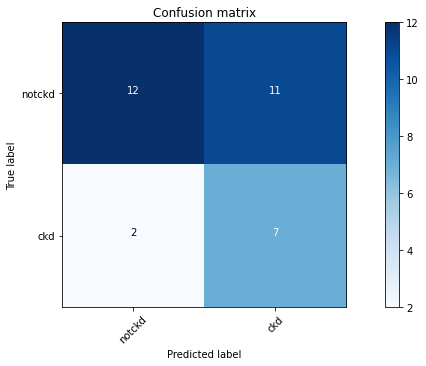

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
#np.set_printoptions(precision=2)

print (classification_report(y_test, yhat,labels=np.unique(yhat)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(11,5))
plot_confusion_matrix(cnf_matrix, classes=['notckd','ckd'],normalize= False,  title='Confusion matrix')

You can also easily use the __f1_score__ from sklearn library:


In [43]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6120495495495495

Let's try the jaccard index for accuracy:


In [44]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.35

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?


### Linear kernel

In [45]:
snapml_svm2 = SupportVectorMachine(class_weight='balanced', kernel='linear', random_state=25, n_jobs=4, fit_intercept=False)
snapml_svm2.fit(X_train, y_train) 
yhat2 = snapml_svm2.predict(X_test)
# print the F1-score and jaccard_score
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("precision score: %.4f" % precision_score(y_test, yhat2))
print("Accuracy score: %.4f" % accuracy_score(y_test, yhat2))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2))

Avg F1-score: 1.0000
precision score: 1.0000
Accuracy score: 1.0000
Jaccard score: 1.0000


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Confusion matrix, without normalization
[[23  0]
 [ 0  9]]


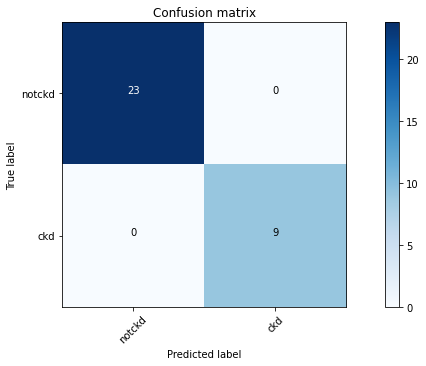

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2)
#np.set_printoptions(precision=2)

print (classification_report(y_test, yhat2,labels=np.unique(yhat2)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(11,5))
plot_confusion_matrix(cnf_matrix, classes=['notckd','ckd'],normalize= False,  title='Confusion matrix')

### Thank you for completing this lab!

